<table align="left">
  <td>
    <a href="https://is.gd/mqJ4qT" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## Transfer Learning + CNN - MNIST Fashion Dataset

En este notebook utilizaremos el dataset de MNIST Fashion para entrenar una red neuronal convolucional (CNN) para clasificar imágenes de ropa. 

El dataset MNIST Fashion contiene 70,000 imágenes en escala de grises de 28x28 píxeles, cada una de las cuales pertenece a una de las 10 clases de ropa. El dataset está dividido en 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba. Cada imagen está etiquetada con una sola etiqueta de clase, que es un entero de 0 a 9.

### **Transfer Learning**

El aprendizaje por transferencia es un método de aprendizaje automático en el que **un modelo desarrollado para una tarea se reutiliza** como punto de partida para un modelo en una segunda tarea.

Es un enfoque popular en el aprendizaje profundo, en el que se utilizan modelos preentrenados como punto de partida en tareas de visión por ordenador y procesamiento del lenguaje natural, dados los enormes recursos de computación y tiempo necesarios para desarrollar modelos de redes neuronales en estos problemas y por los enormes saltos de habilidad que proporcionan en problemas relacionados.

<a href="https://tinyurl.com/yauxq2ap"><img src="https://machinelearningmastery.com/wp-content/uploads/2017/09/Three-ways-in-which-transfer-might-improve-learning.png" alt="experimentos" border="0" width="500" height="250"></a>


## **Paso 1.** Importar las librerías

In [1]:

import tensorflow as tf
from tensorflow import keras
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model 
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K 
K.set_image_data_format('channels_last')



# to make this notebook's output stable across runs
np.random.seed(42)


## **Paso 2.** Cargar el dataset. 

Se utilizará el Fashion MNIST. El dataset contiene 70,000 imagenes en escala de grises de 28x28 pixeles cada una, organizadas en 10 clases.

* Se utiliza keras para cargar el dataset. 
* Se realiza la separación del batch para entrenamiento y testeo, dejando 60,000 imagenes en escala de griste de de 28x28 pixeles para el set de entrenamiento. 

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# transform to rgb as required by VGG
X_train_full=tf.image.grayscale_to_rgb(tf.expand_dims(X_train_full, axis=3)) 
X_test=tf.image.grayscale_to_rgb(tf.expand_dims(X_test, axis=3))

#resize to minimum size of (32x32
X_train_full=tf.image.resize_with_pad(X_train_full,32,32)
X_test=tf.image.resize_with_pad(X_test,32,32)

In [4]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

X_train_full = X_train_full.numpy()
X_test = X_test.numpy()

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,y_train_full, test_size=0.1)

In [6]:
X_train.shape

(54000, 32, 32, 3)

### Las etiquetas son los IDs de las clases, representados de 0 a 9. 

In [7]:
# nombres de las clases
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# La primera imagen en el set de entrenamiento es una Coat. 
class_names[y_train_full[0]]

'Ankle boot'

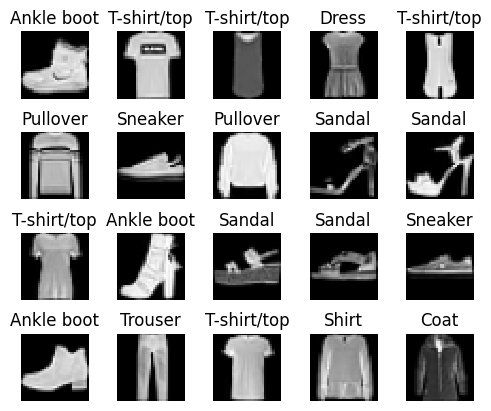

In [8]:
#Imagenes del dataset
n_rows = 4
n_cols = 5
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train_full[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

### Data Augmentation

Dado que el conjunto de datos se compone de pequeñas fotos de objetos, no queremos utilizar aumentos que distorsionen demasiado las imágenes, para poder conservar y utilizar las características útiles de las mismas.

Los tipos de aumentos aleatorios que se utilizarán son:: 
 - giro horizontal, 
 - desplazamientos del 10% en la altura y la anchura de la imagen.

In [9]:
# create data generator
traingen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
validgen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

#Fit the augmentation method to the data
traingen.fit(X_train)
validgen.fit(X_valid)

# prepare iterator - DA_train = data augmentation x_train, y_train
DA_train = traingen.flow(X_train, y_train, batch_size=64)
DA_valid = validgen.flow(X_valid, y_valid, batch_size=64)

## **Paso 3.** Creación del modelo.

### Descargar el modelo VGG 16

ImageNet es un proyecto de investigación para desarrollar una gran base de datos de imágenes con anotaciones, por ejemplo, imágenes y sus descripciones.

El reto de reconocimiento visual a gran escala de ImageNet es una referencia en la clasificación y detección de categorías de objetos en cientos de categorías de objetos y millones de imágenes. El reto se ha celebrado anualmente desde 2010 hasta la actualidad, atrayendo la participación de más de cincuenta instituciones.

En la tarea de clasificación, las imágenes deben clasificarse en una de las 1.000 categorías diferentes.

En los últimos años se han utilizado modelos de redes neuronales convolucionales muy profundas para ganar estos retos y los resultados en las tareas han superado el rendimiento humano. 

[Referencia](https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/)

<a href="https://tinyurl.com/22c8hpcq"><img src="https://miro.medium.com/max/831/1*7Ip2_SeOz_BoruHEytEMlQ.png" alt="experimentos" border="0" width="500" height="350"></a>


[Detalles VGG Keras: ](https://keras.io/api/applications/vgg/#:~:text=The%20default%20input%20size%20for,specific%20kind%20of%20input%20preprocessing.)


La clase VGG() toma algunos argumentos que sólo pueden interesarle si desea utilizar el modelo en su propio proyecto, por ejemplo, para el aprendizaje por transferencia.


- include_top (True): Si se incluyen o no las capas de salida del modelo. **No se necesita esto si estás ajustando el modelo en tu propio problema.**

- weights ('imagenet'): Qué pesos cargar. Se puede especificar None para no cargar pesos pre-entrenados si se está interesado en entrenar el modelo desde cero.

- input_tensor (None): Una nueva capa de entrada si se tiene la intención de ajustar el modelo en nuevos datos de un tamaño diferente.

- input_shape (Ninguno): El tamaño de las imágenes que se espera que tome el modelo si cambias la capa de entrada. (**3 input channels, and width and height should be no smaller than 32**)

- pooling (None): El tipo de pooling a utilizar cuando se entrena un nuevo conjunto de capas de salida.

- clases (1000): El número de clases (por ejemplo, el tamaño del vector de salida) para el modelo.




In [10]:
from keras.applications.vgg16 import VGG16

In [11]:
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

In [12]:
VGG16_model = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3), classes=10)
VGG16_model.trainable = False

In [13]:
## Modelo Secuencial Keras + VGG16
model = Sequential()
model.add(VGG16_model)
model.add(Flatten())
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [14]:
#Add the Dense layers along with activation
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dense(128,activation=('relu')))
model.add(Dense(10,activation=('softmax'))) #This is the classification layer

## **Paso 4.** Compilando el modelo y entrenando el modelo. 


*   **loss**: "sparse_categorical_crossentropy", se utiliza está función dado que se cuenta con un número de etiquetas escasas (sparse) - no binarias.
*   **optimizer** = Adam. 
*   **metrics**: Exactitud (accuracy)


In [15]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

### 4.1 Callbacks - Guardar el mejor modelo durante el entrenamiento

- Al utilizar datos de validación durante el entrenamiento es posible salvar el ultimo mejor modelo.
- Actualizar la variable exp_name con el nombre del experimento a realizar.

In [16]:
exp_name = "EXP_12_TL_VGG16"
# Tensorflow savemodel format
best_model_name = "Trained_Models/fashion_model_" + exp_name


In [17]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(best_model_name, save_best_only=True)
lrr= ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [18]:
steps = int(X_train.shape[0] / 64)
stepsVal = int(X_valid.shape[0] / 64)

history = model.fit(DA_train, steps_per_epoch=steps, epochs=100, validation_data=(DA_valid), validation_steps=stepsVal, callbacks=[checkpoint_cb,lrr], verbose=1) 

Epoch 1/100
843/843 [==============================] - 17s 17ms/step - loss: 0.5991 - accuracy: 0.7796 - val_loss: 0.4993 - val_accuracy: 0.8164
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_EXP_12_TL_VGG16\assets
Epoch 2/100
843/843 [==============================] - 15s 18ms/step - loss: 0.4729 - accuracy: 0.8261 - val_loss: 0.5473 - val_accuracy: 0.8029
Epoch 3/100
843/843 [==============================] - 15s 17ms/step - loss: 0.4461 - accuracy: 0.8333 - val_loss: 0.4722 - val_accuracy: 0.8187
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_EXP_12_TL_VGG16\assets
Epoch 4/100
843/843 [==============================] - 15s 17ms/step - loss: 0.4228 - accuracy: 0.8420 - val_loss: 0.4399 - val_accuracy: 0.8360
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_EXP_12_TL_VGG16\assets
Epoch 5/100
843/843 [==============================] - 15s 17ms/step - loss: 0.4066 - accuracy: 0.8465 - val_loss: 0.4258 - val_accuracy: 0.8453
INFO:tensorflo

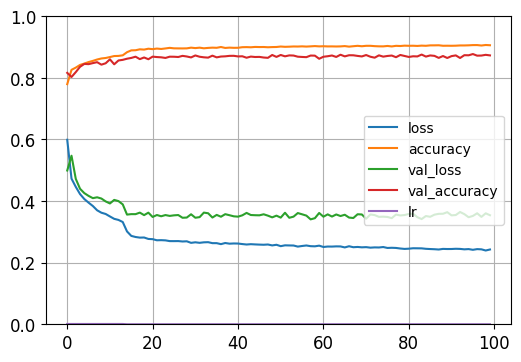

In [19]:
# se utiliza pandas para visualizar la información almacenada en el diccionario de historia de entrenamiento y graficarla. 
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(6, 4))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## **Paso 5.** Evaluación del modelo. 
Se evalua el modelo con el conjunto de datos de prueba.

- X_train: Conjunto de datos de entrenamiento.
- y_train: Etiquetas de los datos de entrenamiento.
- X_valid: Conjunto de datos de validación.
- y_valid: Etiquetas de los datos de validación.
- X_test: Conjunto de datos de prueba.
- y_test: Etiquetas de los datos de prueba.


In [20]:
model = load_model(best_model_name)

In [21]:
scores_train = model.evaluate(X_train, y_train)
scores_valid = model.evaluate(X_valid, y_valid)
scores_test = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3672 - accuracy: 0.8747


In [22]:
print('train loss:', round(scores_train[0]*100,2), '%')
print('valid loss:', round(scores_valid[0]*100,2), '%')
print('test loss:', round(scores_test[0]*100,2), '%')
print("\n")
print('train accuracy:', round(scores_train[1]*100,2), '%')
print('valid accuracy:', round(scores_valid[1]*100,2), '%')
print('test accuracy:', round(scores_test[1]*100,2), '%')

train loss: 23.75 %
valid loss: 34.0 %
test loss: 36.72 %


train accuracy: 90.72 %
valid accuracy: 87.7 %
test accuracy: 87.47 %


## **Paso 6.** Usando el modelo para hacer predicciones. 

Se toman 5 instancias del set de prueba para hacer la predicción. y se imprime la matriz de probabilidad para cada una de las instancias. 

In [22]:
X_new = X_test[10:15]
y_proba = model.predict(X_new)

In [23]:
classes_x = np.argmax(y_proba,axis=1)

In [24]:
# Valores predichos
np.array(class_names)[classes_x]

array(['Coat', 'Sandal', 'Sneaker', 'Dress', 'Coat'], dtype='<U11')

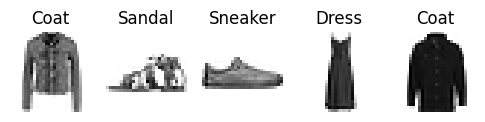

In [27]:
y_new = y_test[10:15]
plt.figure(figsize=(6, 2))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_new[index]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()